# <span style="font-weight: bolder;">Spatial multi-modialty Clustering Demonstration of Human_Lymph_Node A1</span>
+ In this Tutorial, we demonstrate how to use 3d-OT to obtain the clustering results of Human_Lymph_Node A1.
+ Five simulated data consisting of two modalities that together contained the information of the ground truth. 
+ The modalities were designed to simulate the transcriptome, and proteome respectively.

## <span style="font-weight: bolder;">Loading package</span>

In [1]:
from lib_3d_OT.utils import *
import scanpy as sc
import numpy as np
import pandas as pd
import torch
from lib_3d_OT.multi_modialty import *
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

During startup - Warning messages:
1: package ‘methods’ was built under R version 4.3.2 
2: package ‘datasets’ was built under R version 4.3.2 
3: package ‘utils’ was built under R version 4.3.2 
4: package ‘grDevices’ was built under R version 4.3.2 
5: package ‘graphics’ was built under R version 4.3.2 
6: package ‘stats’ was built under R version 4.3.2 
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



In [5]:
import os
os.environ['R_HOME'] = '/home/dbj/anaconda3/envs/r/lib/R'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## <span style="font-weight: bolder;">Loading  data</span>

In [2]:
truth=pd.read_csv('/home/dbj/mouse/SpatialGlue/Human_Lymph_Node/annotation.csv',index_col=0)
file_fold = '/home/dbj/mouse/SpatialGlue/Human_Lymph_Node/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'adata_ADT.h5ad')
adata_omics1.obs['truth']=truth['manual-anno']
adata_omics2.obs['truth']=truth['manual-anno']
adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

+ 3d-OT adopts standard pre-processing steps for the transcriptomic, and protein data. 
+ Specifically, for the transcriptomics data, the gene expression counts are log-transformed and normalized by library size via the SCANPY package. The top 3,000 highly variable genes (HVGs) are selected as input of PCA for dimension reduction. 
+ The protein expresssion counts are normliazed using CLR (Centered Log Ratio).

In [3]:
sc.pp.filter_genes(adata_omics1, min_cells=10)
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)

adata_omics1_high =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=adata_omics2.n_vars-1)

# Protein
adata_omics2 = clr_normalize_each_cell(adata_omics2)
sc.pp.scale(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=adata_omics2.n_vars-1)

## <span style="font-weight: bolder;">Constructing the neighbor graph and training the PointNet++ Encoder</span>

In [6]:
set_seed(7)
graph1 = prepare_data(adata_omics1, location="spatial", nb_neighbors=6).to(device)
graph2 = prepare_data(adata_omics2, location="spatial", nb_neighbors=6).to(device)
input_dim = graph1.express.shape[-1]
hidden_dim=32
model = extractModel(input_dim,hidden_dim,n_heads=4, n_layers=3)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
start_time = time.time()
best_model = train_graph_extractor(graph1,graph2, model ,optimizer, device,epochs=500)

### Get multimodal integrated representation `mixed_modal_features`

In [7]:
with torch.no_grad(): 
    MODEL=extractModel(input_dim=input_dim,hidden_dim=hidden_dim)
    MODEL.to(device)
    MODEL.load_state_dict(best_model)
    MODEL.eval()
    recon1, recon2,mixed_modal_features = MODEL(graph1, graph2)
    mixed_modal_features = mixed_modal_features.squeeze(0) 
    gene_expression_matrix = mixed_modal_features.cpu().detach().numpy()
adata_omics1.obsm['3d-OT']=gene_expression_matrix

## <span style="font-weight: bolder;">We use mclust for clustering</span>

In [10]:
clustering(adata_omics1, n_clusters=10,key='3d-OT', method='mclust',random=2024,n_comp=20)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


## <span style="font-weight: bolder;">The clustering result</span>

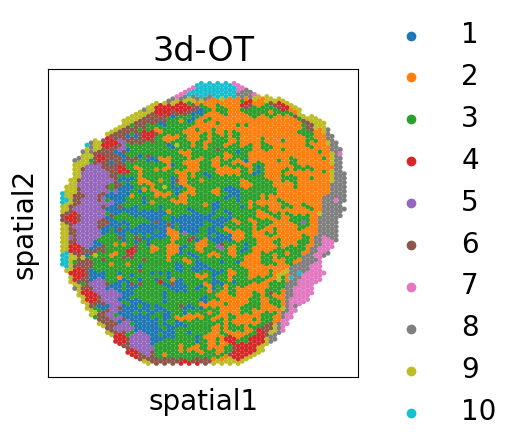

In [12]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots()
sc.pl.embedding(adata_omics1,basis='spatial',color='3d-OT',size=50,ax=ax)

## <span style="font-weight: bolder;">Calculation of six types of supervision indicators</span>

In [13]:
import numpy as np
from sklearn.metrics import (homogeneity_score,mutual_info_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score
)

true_labels = np.array(adata_omics1.obs['truth'])
cluster_labels = np.array(adata_omics1.obs['3d-OT'])

homogeneity = homogeneity_score(true_labels, cluster_labels)
mutual_info = mutual_info_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("Homogeneity:", homogeneity)
print("Mutual Information:", mutual_info)
print("V-Measure:", v_measure)
print("AMI:", ami)
print("NMI:", nmi)
print("ARI:", ari)

Homogeneity: 0.4099481619252866
Mutual Information: 0.6915841864265078
V-Measure: 0.39043921332436543
AMI: 0.38625401019068556
NMI: 0.39043921332436543
ARI: 0.256259941977966
